In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


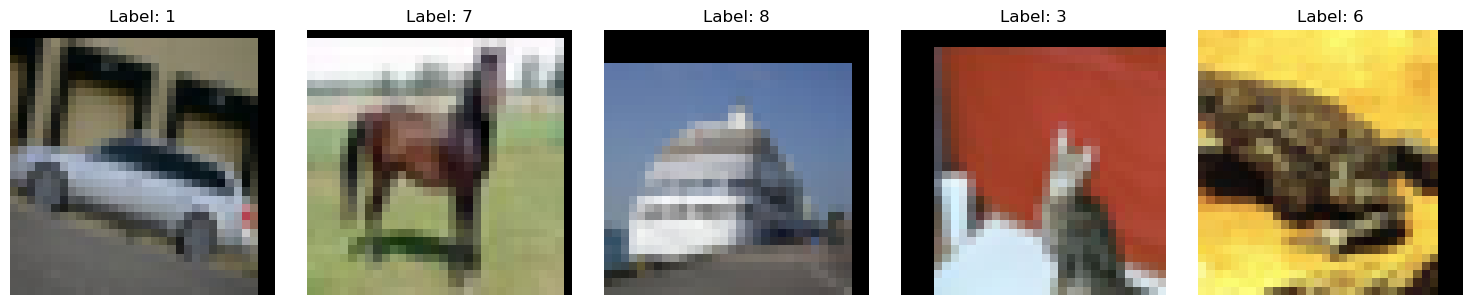

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [8]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [9]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [13]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.0001)

In [14]:
print(device)

cuda


In [15]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:48<00:00,  7.18it/s]


Epoch 1 => Train Loss: 1.4482, Acc: 0.4669 | Val Loss: 1.1375, Acc: 0.5902


Epoch 2/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 2 => Train Loss: 0.9729, Acc: 0.6531 | Val Loss: 0.9478, Acc: 0.6754


Epoch 3/100: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s]


Epoch 3 => Train Loss: 0.7563, Acc: 0.7350 | Val Loss: 0.7056, Acc: 0.7562


Epoch 4/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 4 => Train Loss: 0.6169, Acc: 0.7856 | Val Loss: 0.6384, Acc: 0.7792


Epoch 5/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 5 => Train Loss: 0.5319, Acc: 0.8162 | Val Loss: 0.6082, Acc: 0.8020


Epoch 6/100: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s]


Epoch 6 => Train Loss: 0.4711, Acc: 0.8378 | Val Loss: 0.5178, Acc: 0.8286


Epoch 7/100: 100%|██████████| 352/352 [00:47<00:00,  7.41it/s]


Epoch 7 => Train Loss: 0.4206, Acc: 0.8545 | Val Loss: 0.4495, Acc: 0.8484


Epoch 8/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 8 => Train Loss: 0.3822, Acc: 0.8688 | Val Loss: 0.4253, Acc: 0.8586


Epoch 9/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 9 => Train Loss: 0.3472, Acc: 0.8798 | Val Loss: 0.4237, Acc: 0.8544


Epoch 10/100: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s]


Epoch 10 => Train Loss: 0.3171, Acc: 0.8900 | Val Loss: 0.4138, Acc: 0.8620


Epoch 11/100: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s]


Epoch 11 => Train Loss: 0.2949, Acc: 0.8978 | Val Loss: 0.3791, Acc: 0.8766


Epoch 12/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 12 => Train Loss: 0.2703, Acc: 0.9060 | Val Loss: 0.4444, Acc: 0.8572


Epoch 13/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 13 => Train Loss: 0.2555, Acc: 0.9114 | Val Loss: 0.4093, Acc: 0.8756


Epoch 14/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 14 => Train Loss: 0.2312, Acc: 0.9187 | Val Loss: 0.3556, Acc: 0.8852


Epoch 15/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 15 => Train Loss: 0.2168, Acc: 0.9240 | Val Loss: 0.3366, Acc: 0.8882


Epoch 16/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 16 => Train Loss: 0.1988, Acc: 0.9295 | Val Loss: 0.3945, Acc: 0.8916


Epoch 17/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 17 => Train Loss: 0.1872, Acc: 0.9346 | Val Loss: 0.3396, Acc: 0.8940


Epoch 18/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 18 => Train Loss: 0.1790, Acc: 0.9380 | Val Loss: 0.3617, Acc: 0.8904


Epoch 19/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 19 => Train Loss: 0.1609, Acc: 0.9429 | Val Loss: 0.3320, Acc: 0.8954


Epoch 20/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 20 => Train Loss: 0.1532, Acc: 0.9470 | Val Loss: 0.3730, Acc: 0.8932


Epoch 21/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 21 => Train Loss: 0.1454, Acc: 0.9482 | Val Loss: 0.3516, Acc: 0.9020


Epoch 22/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 22 => Train Loss: 0.1372, Acc: 0.9515 | Val Loss: 0.3811, Acc: 0.8944


Epoch 23/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 23 => Train Loss: 0.1293, Acc: 0.9546 | Val Loss: 0.3428, Acc: 0.8972


Epoch 24/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 24 => Train Loss: 0.1159, Acc: 0.9596 | Val Loss: 0.3811, Acc: 0.8940


Epoch 25/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 25 => Train Loss: 0.1123, Acc: 0.9605 | Val Loss: 0.3437, Acc: 0.9060


Epoch 26/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 26 => Train Loss: 0.1073, Acc: 0.9622 | Val Loss: 0.3482, Acc: 0.9058


Epoch 27/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 27 => Train Loss: 0.0983, Acc: 0.9657 | Val Loss: 0.3427, Acc: 0.9076


Epoch 28/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 28 => Train Loss: 0.1008, Acc: 0.9636 | Val Loss: 0.3599, Acc: 0.9044


Epoch 29/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 29 => Train Loss: 0.0891, Acc: 0.9688 | Val Loss: 0.4076, Acc: 0.9030


Epoch 30/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 30 => Train Loss: 0.0887, Acc: 0.9687 | Val Loss: 0.4070, Acc: 0.9012


Epoch 31/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 31 => Train Loss: 0.0797, Acc: 0.9711 | Val Loss: 0.4244, Acc: 0.8940


Epoch 32/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 32 => Train Loss: 0.0778, Acc: 0.9730 | Val Loss: 0.3902, Acc: 0.9058


Epoch 33/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 33 => Train Loss: 0.0763, Acc: 0.9723 | Val Loss: 0.4390, Acc: 0.8982


Epoch 34/100: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s]


Epoch 34 => Train Loss: 0.0793, Acc: 0.9726 | Val Loss: 0.3737, Acc: 0.9112


Epoch 35/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 35 => Train Loss: 0.0684, Acc: 0.9763 | Val Loss: 0.3759, Acc: 0.9078


Epoch 36/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 36 => Train Loss: 0.0666, Acc: 0.9762 | Val Loss: 0.3975, Acc: 0.9064


Epoch 37/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 37 => Train Loss: 0.0640, Acc: 0.9777 | Val Loss: 0.3868, Acc: 0.9104


Epoch 38/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 38 => Train Loss: 0.0625, Acc: 0.9779 | Val Loss: 0.4022, Acc: 0.9096


Epoch 39/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 39 => Train Loss: 0.0587, Acc: 0.9794 | Val Loss: 0.3858, Acc: 0.9124


Epoch 40/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 40 => Train Loss: 0.0589, Acc: 0.9789 | Val Loss: 0.4180, Acc: 0.9056


Epoch 41/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 41 => Train Loss: 0.0627, Acc: 0.9785 | Val Loss: 0.3806, Acc: 0.9150


Epoch 42/100: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s]


Epoch 42 => Train Loss: 0.0557, Acc: 0.9795 | Val Loss: 0.4345, Acc: 0.9028


Epoch 43/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 43 => Train Loss: 0.0525, Acc: 0.9810 | Val Loss: 0.3637, Acc: 0.9136


Epoch 44/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 44 => Train Loss: 0.0507, Acc: 0.9820 | Val Loss: 0.4176, Acc: 0.9148


Epoch 45/100: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s]


Epoch 45 => Train Loss: 0.0543, Acc: 0.9815 | Val Loss: 0.3840, Acc: 0.9158


Epoch 46/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 46 => Train Loss: 0.0488, Acc: 0.9824 | Val Loss: 0.3898, Acc: 0.9176


Epoch 47/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 47 => Train Loss: 0.0451, Acc: 0.9845 | Val Loss: 0.4168, Acc: 0.9130


Epoch 48/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 48 => Train Loss: 0.0478, Acc: 0.9832 | Val Loss: 0.4302, Acc: 0.9168


Epoch 49/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 49 => Train Loss: 0.0491, Acc: 0.9826 | Val Loss: 0.4217, Acc: 0.9096


Epoch 50/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 50 => Train Loss: 0.0386, Acc: 0.9867 | Val Loss: 0.4164, Acc: 0.9122


Epoch 51/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 51 => Train Loss: 0.0410, Acc: 0.9855 | Val Loss: 0.4291, Acc: 0.9142


Epoch 52/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 52 => Train Loss: 0.0451, Acc: 0.9845 | Val Loss: 0.4322, Acc: 0.9156


Epoch 53/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 53 => Train Loss: 0.0375, Acc: 0.9866 | Val Loss: 0.4298, Acc: 0.9136


Epoch 54/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 54 => Train Loss: 0.0439, Acc: 0.9841 | Val Loss: 0.3838, Acc: 0.9184


Epoch 55/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 55 => Train Loss: 0.0424, Acc: 0.9852 | Val Loss: 0.4286, Acc: 0.9152


Epoch 56/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 56 => Train Loss: 0.0389, Acc: 0.9865 | Val Loss: 0.4711, Acc: 0.9090


Epoch 57/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 57 => Train Loss: 0.0395, Acc: 0.9858 | Val Loss: 0.4555, Acc: 0.9088


Epoch 58/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 58 => Train Loss: 0.0379, Acc: 0.9870 | Val Loss: 0.4145, Acc: 0.9148


Epoch 59/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 59 => Train Loss: 0.0377, Acc: 0.9871 | Val Loss: 0.4348, Acc: 0.9128


Epoch 60/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 60 => Train Loss: 0.0359, Acc: 0.9876 | Val Loss: 0.4310, Acc: 0.9174


Epoch 61/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 61 => Train Loss: 0.0350, Acc: 0.9881 | Val Loss: 0.4523, Acc: 0.9122


Epoch 62/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 62 => Train Loss: 0.0341, Acc: 0.9881 | Val Loss: 0.4271, Acc: 0.9132


Epoch 63/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 63 => Train Loss: 0.0343, Acc: 0.9883 | Val Loss: 0.4574, Acc: 0.9120


Epoch 64/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 64 => Train Loss: 0.0333, Acc: 0.9884 | Val Loss: 0.4583, Acc: 0.9158


Epoch 65/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 65 => Train Loss: 0.0332, Acc: 0.9885 | Val Loss: 0.4597, Acc: 0.9134


Epoch 66/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 66 => Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.4110, Acc: 0.9190


Epoch 67/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 67 => Train Loss: 0.0301, Acc: 0.9890 | Val Loss: 0.4643, Acc: 0.9166


Epoch 68/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 68 => Train Loss: 0.0331, Acc: 0.9886 | Val Loss: 0.4022, Acc: 0.9220


Epoch 69/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 69 => Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.5069, Acc: 0.9102


Epoch 70/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 70 => Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.4479, Acc: 0.9188


Epoch 71/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 71 => Train Loss: 0.0262, Acc: 0.9905 | Val Loss: 0.4464, Acc: 0.9202


Epoch 72/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 72 => Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.4846, Acc: 0.9160


Epoch 73/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 73 => Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.5100, Acc: 0.9160


Epoch 74/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 74 => Train Loss: 0.0313, Acc: 0.9889 | Val Loss: 0.4451, Acc: 0.9172


Epoch 75/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 75 => Train Loss: 0.0332, Acc: 0.9883 | Val Loss: 0.4425, Acc: 0.9174


Epoch 76/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 76 => Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.5245, Acc: 0.9056


Epoch 77/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 77 => Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.4269, Acc: 0.9210


Epoch 78/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 78 => Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.4999, Acc: 0.9118


Epoch 79/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 79 => Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.4794, Acc: 0.9172


Epoch 80/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 80 => Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.4373, Acc: 0.9200


Epoch 81/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 81 => Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.4267, Acc: 0.9188


Epoch 82/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 82 => Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.4803, Acc: 0.9152


Epoch 83/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 83 => Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.4780, Acc: 0.9192


Epoch 84/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 84 => Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.4598, Acc: 0.9194


Epoch 85/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 85 => Train Loss: 0.0218, Acc: 0.9922 | Val Loss: 0.4410, Acc: 0.9236


Epoch 86/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 86 => Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.4480, Acc: 0.9184


Epoch 87/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 87 => Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.4498, Acc: 0.9218


Epoch 88/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 88 => Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.4728, Acc: 0.9176


Epoch 89/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 89 => Train Loss: 0.0304, Acc: 0.9895 | Val Loss: 0.4364, Acc: 0.9162


Epoch 90/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 90 => Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.4334, Acc: 0.9228


Epoch 91/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 91 => Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.4734, Acc: 0.9146


Epoch 92/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 92 => Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.4463, Acc: 0.9174


Epoch 93/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 93 => Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.4717, Acc: 0.9172


Epoch 94/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 94 => Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.4627, Acc: 0.9216


Epoch 95/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 95 => Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.4715, Acc: 0.9166


Epoch 96/100: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s]


Epoch 96 => Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.4426, Acc: 0.9208


Epoch 97/100: 100%|██████████| 352/352 [00:47<00:00,  7.49it/s]


Epoch 97 => Train Loss: 0.0212, Acc: 0.9922 | Val Loss: 0.4844, Acc: 0.9172


Epoch 98/100: 100%|██████████| 352/352 [00:46<00:00,  7.49it/s]


Epoch 98 => Train Loss: 0.0226, Acc: 0.9920 | Val Loss: 0.4563, Acc: 0.9184


Epoch 99/100: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s]


Epoch 99 => Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.5065, Acc: 0.9116


Epoch 100/100: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s]


Epoch 100 => Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.4860, Acc: 0.9192


In [16]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("adamW_weight_decay1.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

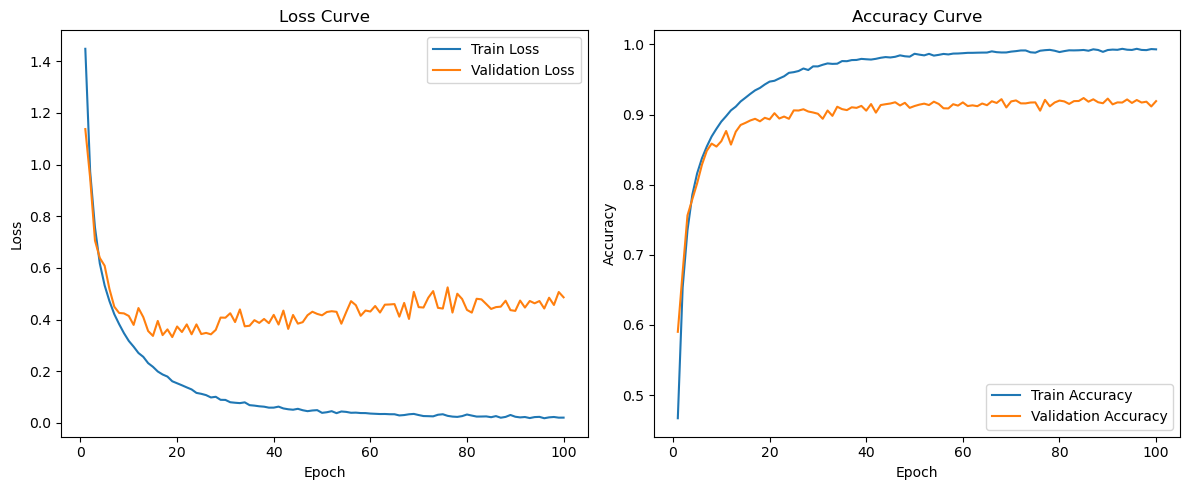

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [18]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.01%


In [19]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model_adamW_weight1.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.63%
